### 1. Import Packages

In [107]:
# Librerie di base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librerie per la Data Imputation
from sklearn.impute import KNNImputer

# Libreire per la Data Standardization
from sklearn.preprocessing import StandardScaler

# Librerie per il Machine Learning
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, train_test_split, cross_val_score

# Librerie per la Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV

# Librerie per la Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

print('All packages successfully loaded')

All packages successfully loaded


### 2. Load Data & Peak Sheet

In [108]:
df = pd.read_csv('../../../data/ST001142.csv')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Sample ID", "Cell Culture Media", "LINE", "Doubling time (hr)"], inplace=True)
df.drop(columns=["C4-POS RAW FILE", "HILIC-POS RAW FILE", "HILIC-NEG RAW FILE"], inplace=True)

# Visualizziamo le prime 5 righe del dataset
df.head()

,Classifications,Gender,glycine,alanine,serine,threonine,methionine,aspartate,glutamate,asparagine,...,heptanoylcarnitine,lauroylcarnitine,myristoylcarnitine,palmitoylcarnitine,stearoylcarnitine,oleylcarnitine,arachidonyl_carnitine,sarcosine,beta-alanine,anserine
0,lymphoma_Hodgkin,female,6292.0,322578,293711,202252,238456,606358,2181098,417699,...,982.0,691.0,1917.0,6166.0,1881.0,1461.0,162.0,4572.0,17619.0,1241.0
1,colorectal,male,5546.0,186838,232838,227880,317757,359830,1970187,480737,...,1019.0,390.0,638.0,5604.0,3396.0,1856.0,246.0,2938.0,20870.0,941.0
2,melanoma,male,8754.0,133239,198453,1226706,819850,144701,2519205,16961,...,4125.0,2386.0,3425.0,2481.0,864.0,1190.0,77.0,2536.0,84428.0,1011.0
3,melanoma,female,10951.0,223066,206201,443958,210194,185492,1162426,265067,...,791.0,2027.0,7926.0,28683.0,7590.0,14329.0,175.0,1816.0,11026.0,716.0
4,melanoma,male,3483.0,535354,202987,121196,203591,119306,763633,492837,...,339.0,2500.0,3618.0,22504.0,4225.0,7683.0,239.0,13676.0,47337.0,650.0


In [109]:
# Eliminiamo i tre campioni con classificazione "other" in quanto potrebbero essere fuorvianti
print(df.Classifications.value_counts())
df.drop(df[df["Classifications"] == "other"].index, inplace=True)

lung_NSC                 124
colorectal                55
melanoma                  54
ovary                     51
lung_small_cell           51
breast                    49
glioma                    46
pancreas                  41
stomach                   37
AML                       33
upper_aerodigestive       30
endometrium               28
multiple_myeloma          26
esophagus                 26
liver                     26
urinary_tract             25
kidney                    24
soft_tissue               17
lymphoma_DLBCL            17
neuroblastoma             17
B-cell_lymphoma_other     15
T-cell_ALL                15
CML                       14
thyroid                   12
B-cell_ALL                12
T-cell_lymphoma_other     10
lymphoma_Burkitt          10
mesothelioma               8
lymphoma_Hodgkin           8
osteosarcoma               8
bile_duct                  8
Ewings_sarcoma             8
prostate                   7
leukemia_other             5
medulloblastom

### 2.1 Data Cleaning

Per quanto riguarda il data cleaning del dataset, è necessario convertire i valori testuali in valori binari della feature "Gender".

In [110]:
# Eliminiamo le righe con valori nulli all'interno della colonna "Gender"
df = df.dropna(subset=["Gender"])

# Convertiamo i valori di natura categorica in valori numerici
df['Gender'] = df['Gender'].apply(lambda x: 1 if x in ['female'] else 0)

# Visualizziamo le prime 5 righe del dataset
df.head()

,Classifications,Gender,glycine,alanine,serine,threonine,methionine,aspartate,glutamate,asparagine,...,heptanoylcarnitine,lauroylcarnitine,myristoylcarnitine,palmitoylcarnitine,stearoylcarnitine,oleylcarnitine,arachidonyl_carnitine,sarcosine,beta-alanine,anserine
0,lymphoma_Hodgkin,1,6292.0,322578,293711,202252,238456,606358,2181098,417699,...,982.0,691.0,1917.0,6166.0,1881.0,1461.0,162.0,4572.0,17619.0,1241.0
1,colorectal,0,5546.0,186838,232838,227880,317757,359830,1970187,480737,...,1019.0,390.0,638.0,5604.0,3396.0,1856.0,246.0,2938.0,20870.0,941.0
2,melanoma,0,8754.0,133239,198453,1226706,819850,144701,2519205,16961,...,4125.0,2386.0,3425.0,2481.0,864.0,1190.0,77.0,2536.0,84428.0,1011.0
3,melanoma,1,10951.0,223066,206201,443958,210194,185492,1162426,265067,...,791.0,2027.0,7926.0,28683.0,7590.0,14329.0,175.0,1816.0,11026.0,716.0
4,melanoma,0,3483.0,535354,202987,121196,203591,119306,763633,492837,...,339.0,2500.0,3618.0,22504.0,4225.0,7683.0,239.0,13676.0,47337.0,650.0


### 3. Extract X & Y

In [111]:
X = df.drop(columns=['Classifications'])
X_features_names = X.columns
y = df.Classifications

### 3.1 Data Imputation

In [112]:
# KNNImputer
imputer_knn = KNNImputer(n_neighbors=1)
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

/var/folders/dv/cqkd8q211lb6w_8jd__s86d40000gn/T/ipykernel_14250/856958982.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X[:] = imputer_knn.fit_transform(X)


### 3.2 Train-test Split

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.2, random_state=42)

### 3.3 Data Standardization

In [114]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Initial Model Build

In [115]:
# Definiamo il modello AdaBoost Classifier con gli iperparametri di default
model = AdaBoostClassifier()

# Addestriamo il modello
model.fit(X_train_scaled, y_train)

# Eseguiamo le previsioni sui dati di test
y_pred_knn = model.predict(X_test_scaled)

### 5. Initial Model Evalutation

In [116]:
# Valutiamo le prestazioni del modello con gli iperparametri di default
accuracy_knn = metrics.accuracy_score(y_test, y_pred_knn)
report = metrics.classification_report(y_test, y_pred_knn)

print(f'Accuratezza: {accuracy_knn}')
print(f'Report: {report}')

Accuratezza: 0.08379888268156424
Report:                        precision    recall  f1-score   support

                  AML       0.04      0.25      0.07         4
           B-cell_ALL       0.00      0.00      0.00         2
B-cell_lymphoma_other       0.00      0.00      0.00         2
       Ewings_sarcoma       0.00      0.00      0.00         1
           T-cell_ALL       0.00      0.00      0.00         3
T-cell_lymphoma_other       0.00      0.00      0.00         4
               breast       0.00      0.00      0.00        13
           colorectal       0.00      0.00      0.00        11
          endometrium       0.00      0.00      0.00         6
            esophagus       0.00      0.00      0.00         5
               glioma       0.00      0.00      0.00        11
               kidney       0.00      0.00      0.00         4
       leukemia_other       0.00      0.00      0.00         2
                liver       0.00      0.00      0.00         8
             

/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Abbiamo un'accuratezza del 51%, una Precision del 46% e una Recall del 40%. Proviamo con la K-Fold Cross Validation.

In [117]:
# K-Fold Cross Validation

# Testiamo diverse configurazioni di K (range: 5-10)
max = 0
k_best = 0
model = AdaBoostClassifier()
for k in range(5, 11): 
    kfolds = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_knn, y, cv=kfolds)
    mean = np.mean(scores)
    if mean > max: 
        max = mean
        k_best = k
    print(f"K={k}, Accuratezza Media: {mean}")

print("-------------------------------------------")
print(f"K ottimale: {k_best}")
print(f"Accuratezza Media ottimale: {max}")

K=5, Accuratezza Media: 0.15345552696001505
K=6, Accuratezza Media: 0.13772749259326442
K=7, Accuratezza Media: 0.1377952755905512
K=8, Accuratezza Media: 0.15237894144144143
K=9, Accuratezza Media: 0.1513131313131313
K=10, Accuratezza Media: 0.15137328339575531
-------------------------------------------
K ottimale: 5
Accuratezza Media ottimale: 0.15345552696001505


Il numero ottimale di fold è 7. 

In [ ]:
# Creiamo l'oggetto KFold per la Cross-Validation con il numero di fold ottimale
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

### 6. Hyperparameters Optimization

L'**ottimizzazione degli iperparametri** è un passo fondamentale nello sviluppo di modelli predittivi robusti. Infatti, aderire ai parametri predefiniti impedisce ai modelli di raggiungere il massimo delle prestazioni. A tale scopo, utilizziamo la tecnica **Grid Search**.

In [78]:
# Creiamo un nuovo modello XGBClassifier
model_2 = AdaBoostClassifier()

# Definiamo la griglia con i parametri da testare
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],           
    'learning_rate': [0.01, 0.1, 1.0, 10],        
    'estimator': [None, DecisionTreeClassifier(max_depth=1)],
    'algorithm': ['SAMME', 'SAMME.R'],    
    'random_state': [42]                      
}

# Grid Search
grid_search = GridSearchCV(model_2, param_grid, scoring='accuracy', cv=kfolds, n_jobs=-1)
grid_search.fit(X_knn, y)

# Visualizziamo i risultati
best_params = grid_search.best_params_
print("Iperparametri migliori:", best_params)

Iperparametri migliori: {'algorithm': 'SAMME.R', 'estimator': None, 'learning_rate': 0.01, 'n_estimators': 300, 'random_state': 42}


In [79]:
# Utilizziamo gli iperparametri ottimizzati per creare un nuovo modello
best_model = AdaBoostClassifier(**best_params)
best_model.fit(X_train, y_train)
y_pred_knn = best_model.predict(X_test)

In [80]:
# Valutiamo le prestazioni del modello con gli iperparametri di default
accuracy_knn = metrics.accuracy_score(y_test, y_pred_knn)
precision_knn = metrics.precision_score(y_test, y_pred_knn)
recall_knn = metrics.recall_score(y_test, y_pred_knn)
f1_knn = metrics.f1_score(y_test, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test, y_pred_knn)

print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.5777777777777777
Precision: 0.6666666666666666
Recall: 0.14634146341463414
F1-score: 0.24
ROC AUC: 0.5425584868093579


In [81]:
# KFold Cross Validation
scores = cross_val_score(best_model, X_knn, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.5658482142857143


### 7. Feature Selection

In [82]:
max_fs = 0 
k_fs = 0
best_features = []

for k in range(2, len(X_knn.columns)):
    top_features = SelectKBest(score_func=chi2, k=k).fit(X_knn, y).get_support(indices=True)
    X_top = X_knn.iloc[:, top_features]
    
    scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_fs: 
        max_fs = mean
        k_fs = k
        best_features = X_knn.columns[top_features].tolist()

    print(f"K={k}, Accuratezza Media: {mean}")

print(f"K ottimale: {k_fs}")
print(f"Accuratezza media ottimale: {max_fs}")
print(f"Features ottimali: {best_features}")

K=2, Accuratezza Media: 0.5491071428571429
K=3, Accuratezza Media: 0.546875
K=4, Accuratezza Media: 0.5457589285714286
K=5, Accuratezza Media: 0.5424107142857143
K=6, Accuratezza Media: 0.5412946428571429
K=7, Accuratezza Media: 0.5379464285714286
K=8, Accuratezza Media: 0.5379464285714286
K=9, Accuratezza Media: 0.5401785714285714
K=10, Accuratezza Media: 0.5379464285714286
K=11, Accuratezza Media: 0.5345982142857143


KeyboardInterrupt: 

In [ ]:
X_top = X_knn[best_features]
scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.8099415204678362


Visualizziamo la matrice di correlazione tra le features ottenute.

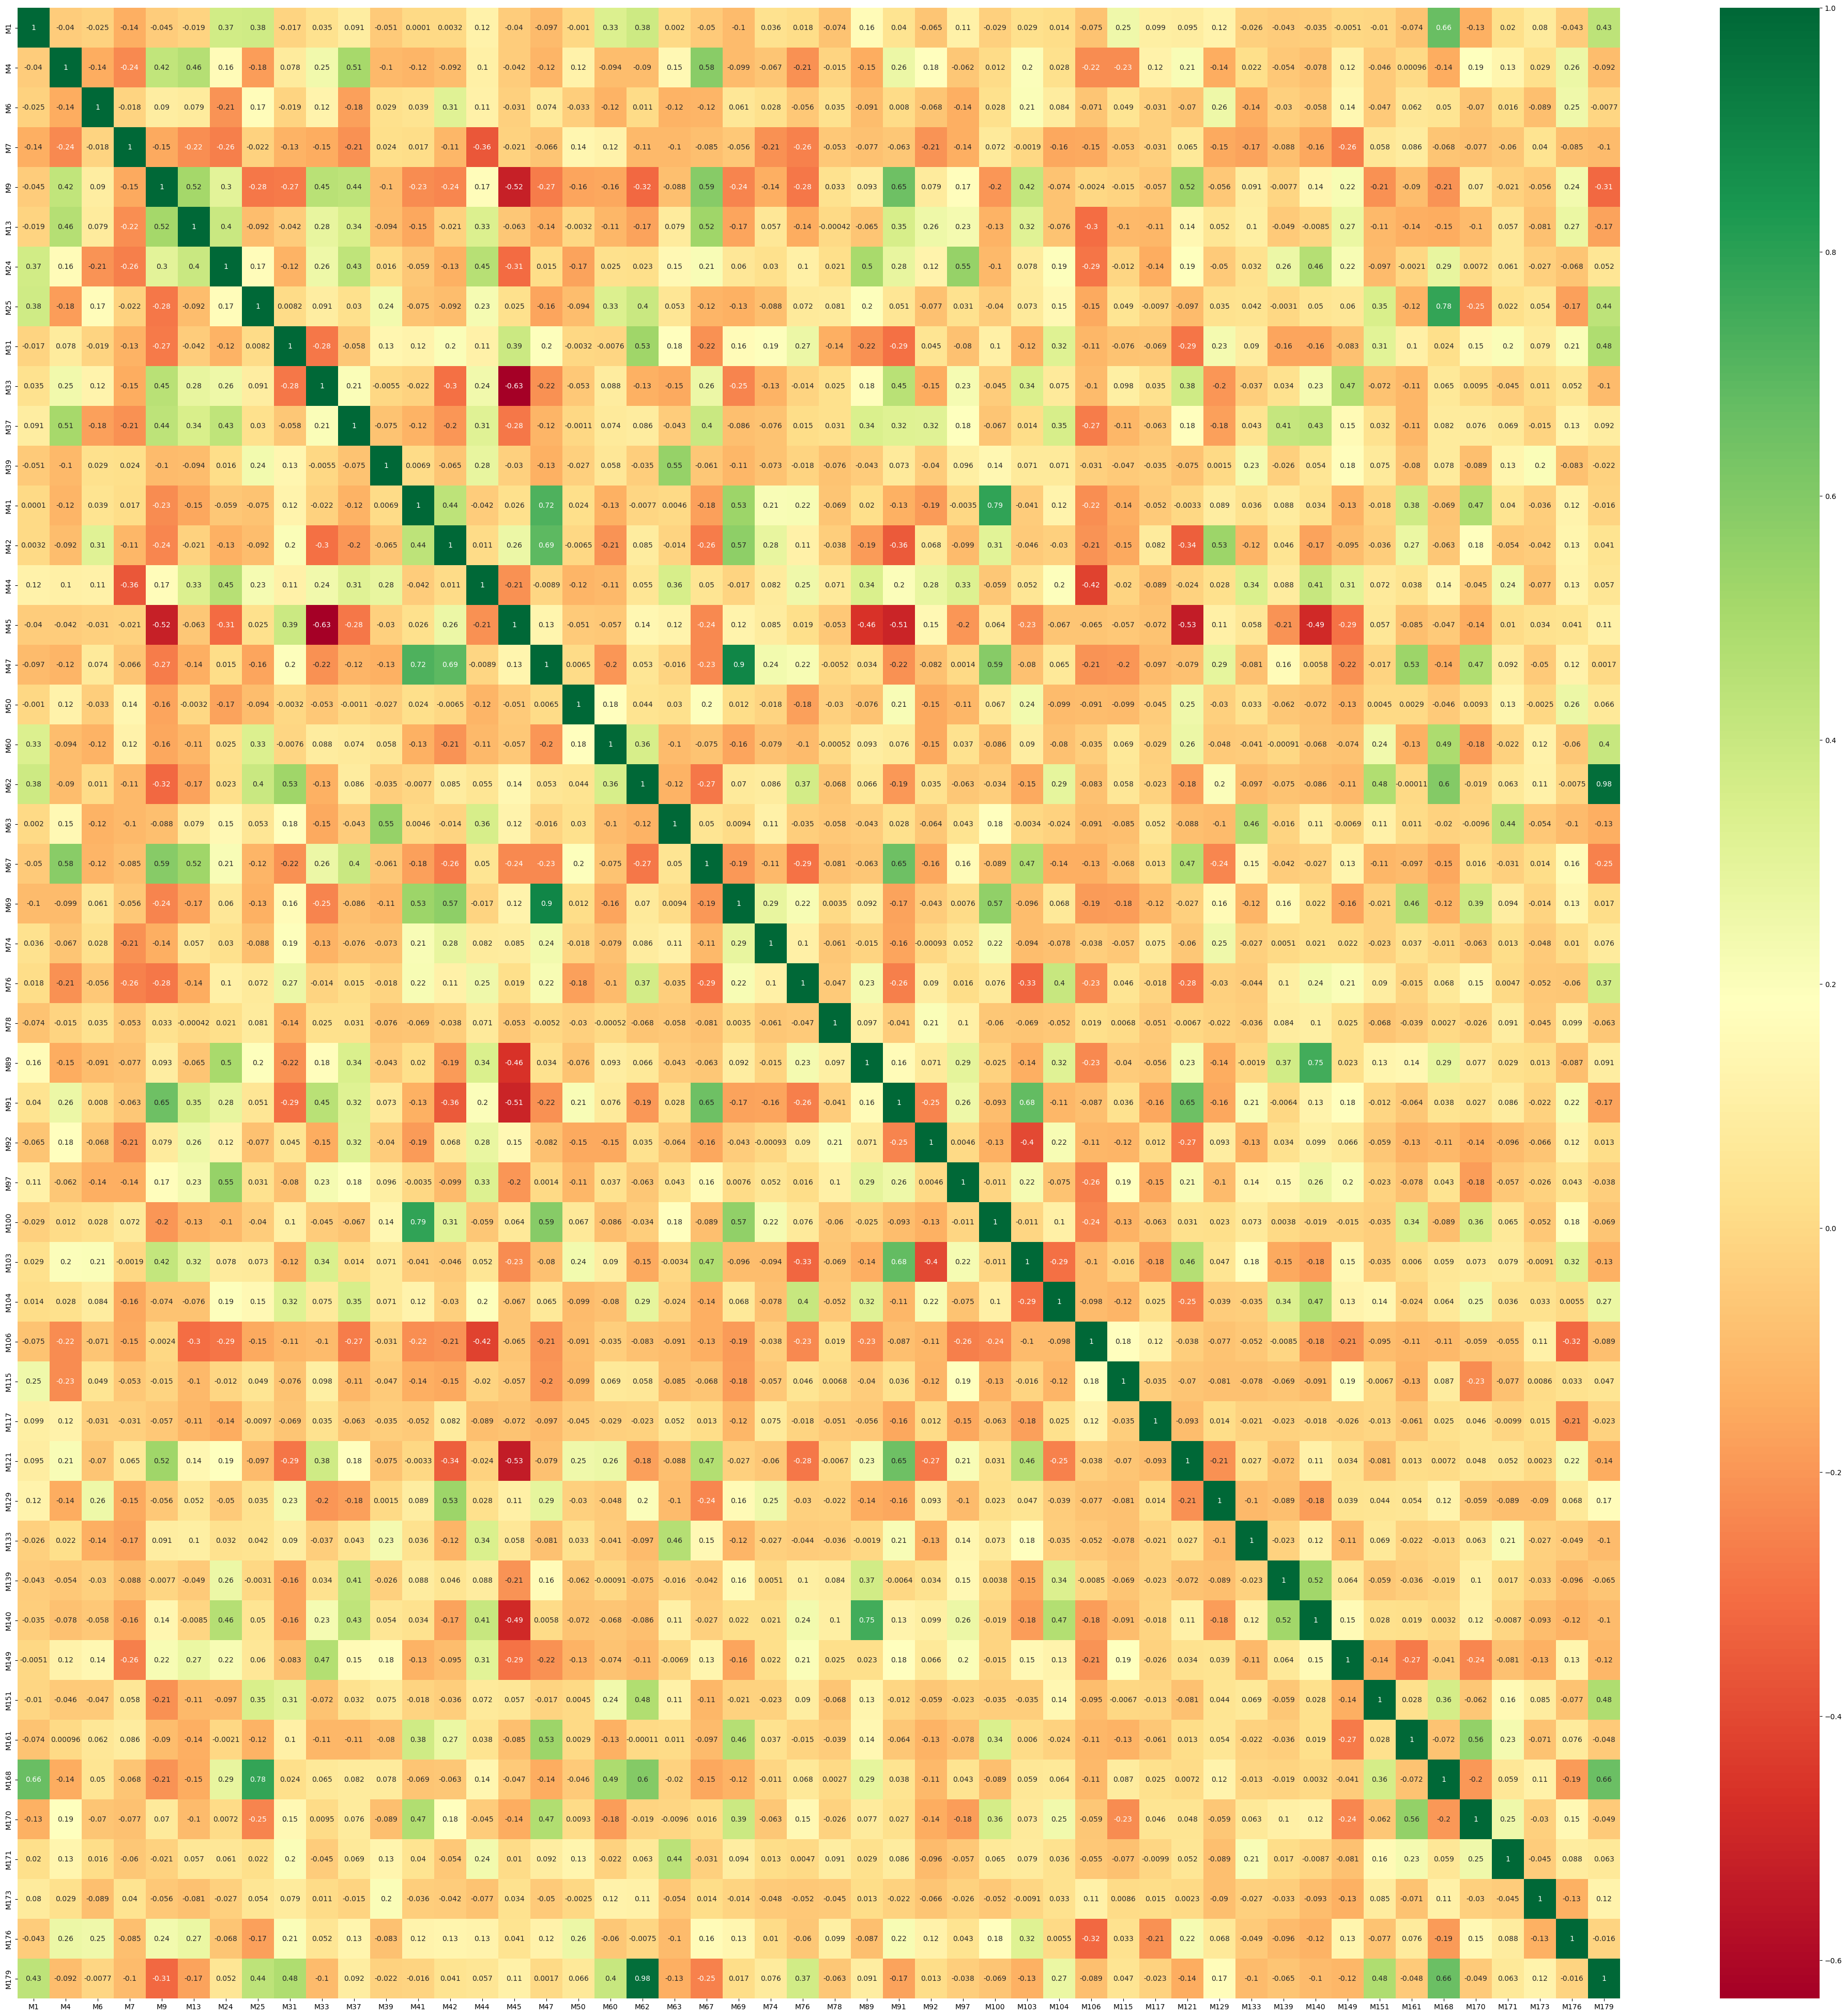

In [ ]:
# Otteniamo le correlazioni tra le features
corrmat = X_top.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(50, 50))

# Generiamo il grafico delle correlazioni
g=sns.heatmap(X_top[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 8. PCA

In [ ]:
pca = PCA()
pca.fit(X_knn)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.8) + 1
print("Numero di componenti principali:", d)

pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_knn)

Numero di componenti principali: 3


In [ ]:
scores = cross_val_score(best_model, X_reduced, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.6140350877192982


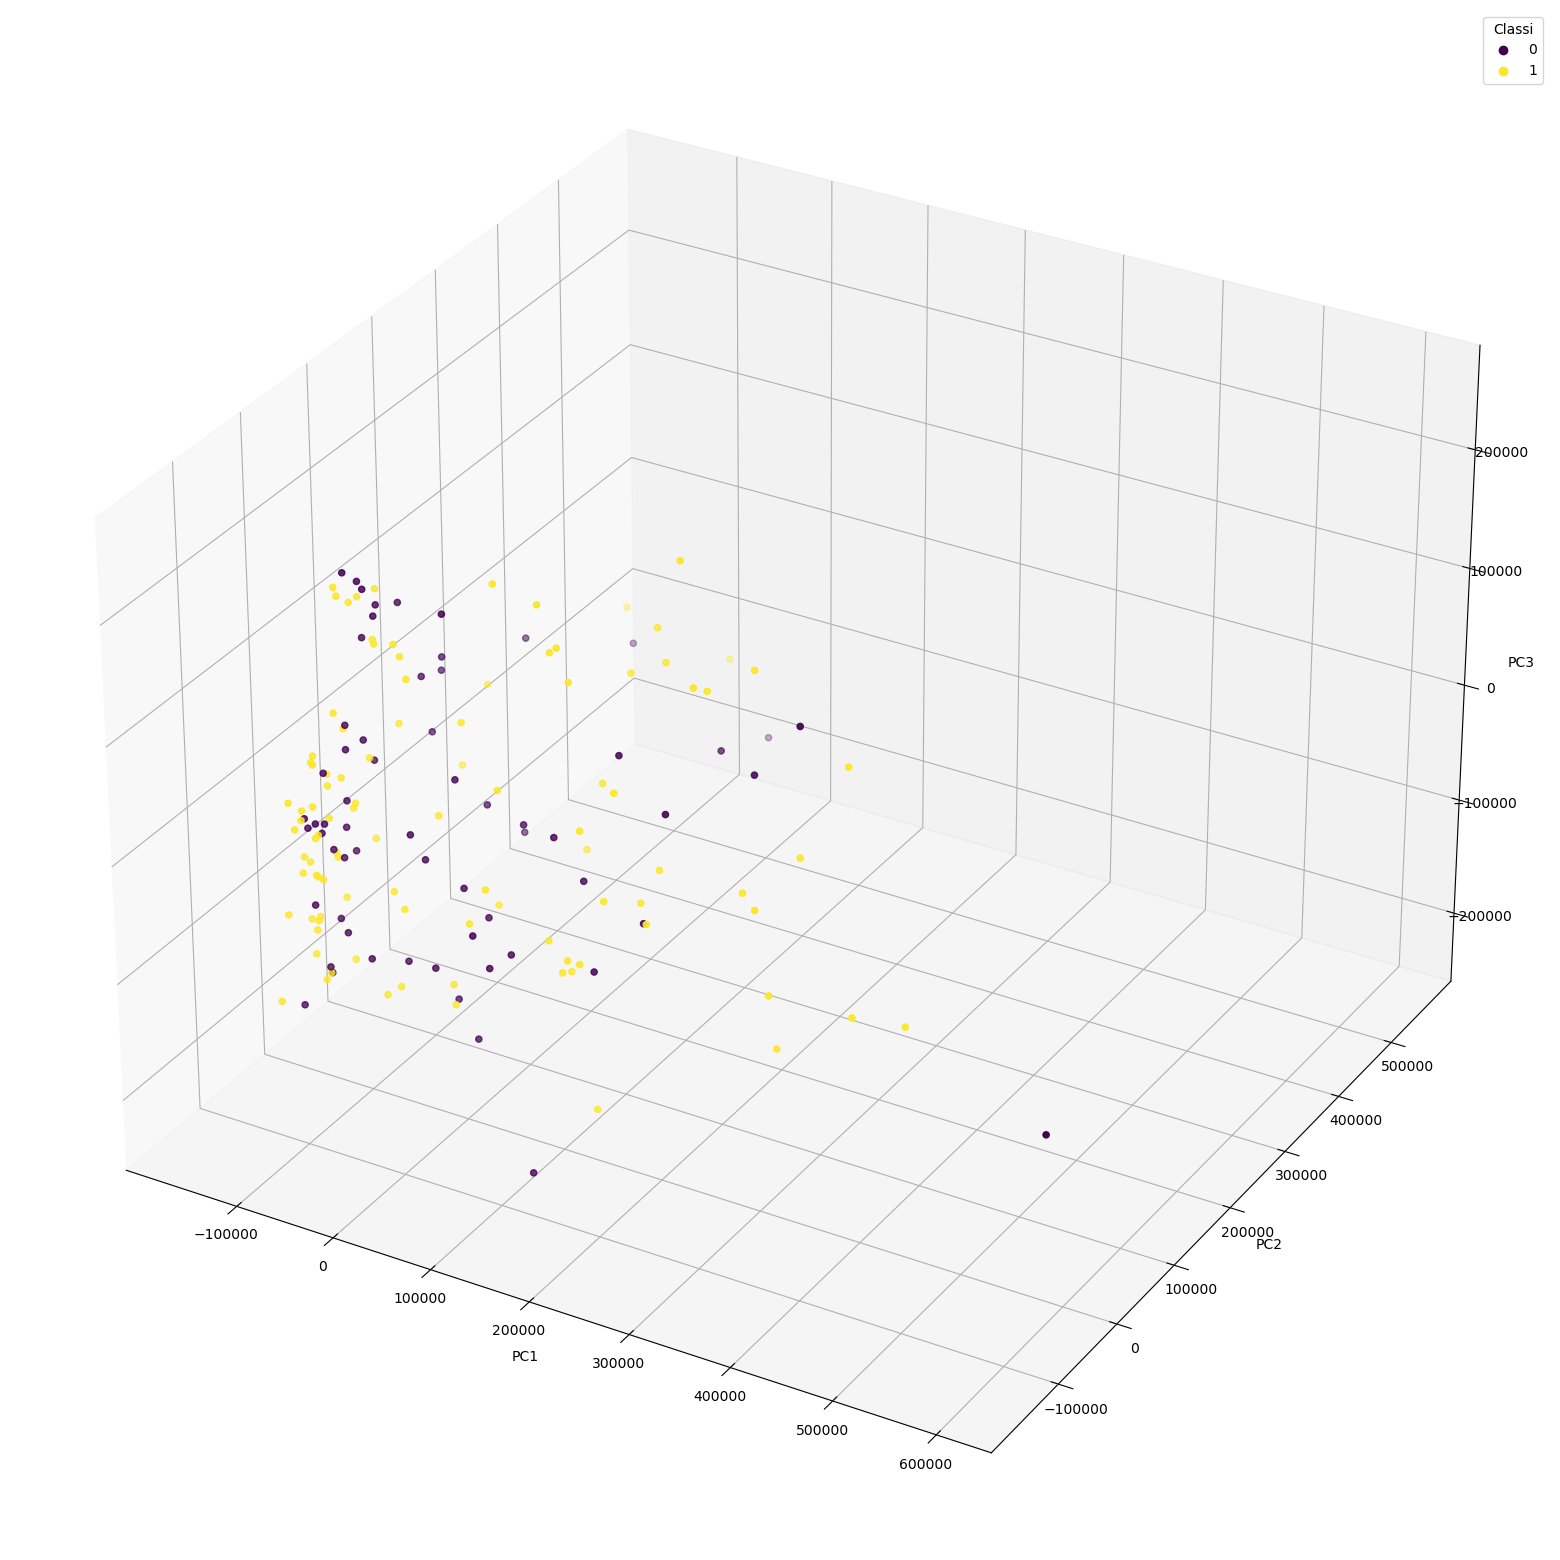

In [ ]:
# Creazione di un grafico 3D
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plotting dei punti nel grafico 3D
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='viridis')

# Aggiungi etichette agli assi
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Aggiungiamo una legenda per i colori
legend = ax.legend(*scatter.legend_elements(), title='Classi')

# Mostriamo il grafico
plt.show()


### 9. Results

Elenchiamo i risultati migliori: 

In [ ]:
# Numero ottimale di fold 
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

# Modello AdaBoost Classifier con gli iperparametri ottimizzati
model = AdaBoostClassifier(**best_params)

# K-Fold Cross Validation del modello con le features ottimali
scores = cross_val_score(model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media delle {k_fs} migliori features: {scores.mean()}')

Accuratezza media delle 50 migliori features: 0.8099415204678362
